# Final EDA and Linear Regression Model

In [25]:
# Load in necessary packages
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.graphics.regressionplots import plot_partregress_grid
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [26]:
# Read in csv file
coffee = pd.read_csv('linear.csv')

## EDA Plots

<Axes: title={'center': 'Correlation Matrix of Scale Scored Variables'}>

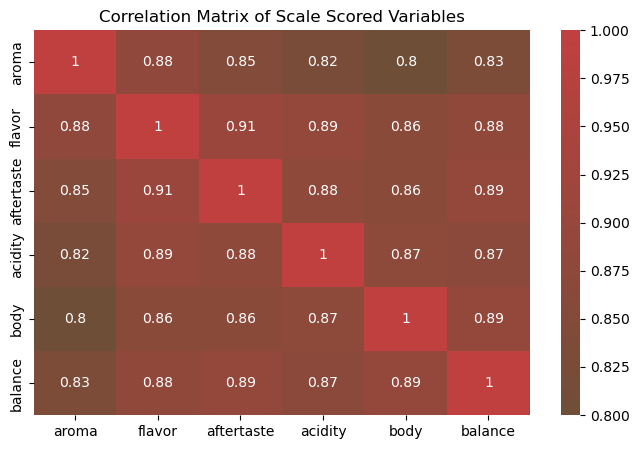

In [27]:
# Plot that shows extreme multicolinearity and restricted range of variables in total_quality

from matplotlib.colors import LinearSegmentedColormap
corr = coffee.loc[:, 'aroma':'balance'].corr()
plt.figure(figsize=(8,5))
plt.title("Correlation Matrix of Scale Scored Variables")

custom_cmap = LinearSegmentedColormap.from_list(
    'coffee_red', ['#6F4E37', '#C04040'], N=256)
sns.heatmap(corr, annot=True, cmap=custom_cmap)

### Buttons for Heatmap:

- Turn numbers on and off (annot=True or annot=False)
- Let user decide what variables to include from list (aroma, flavor, aftertaste, acidity, body, balance)
- Change method of correlation (pearson, spearman, kendall)?

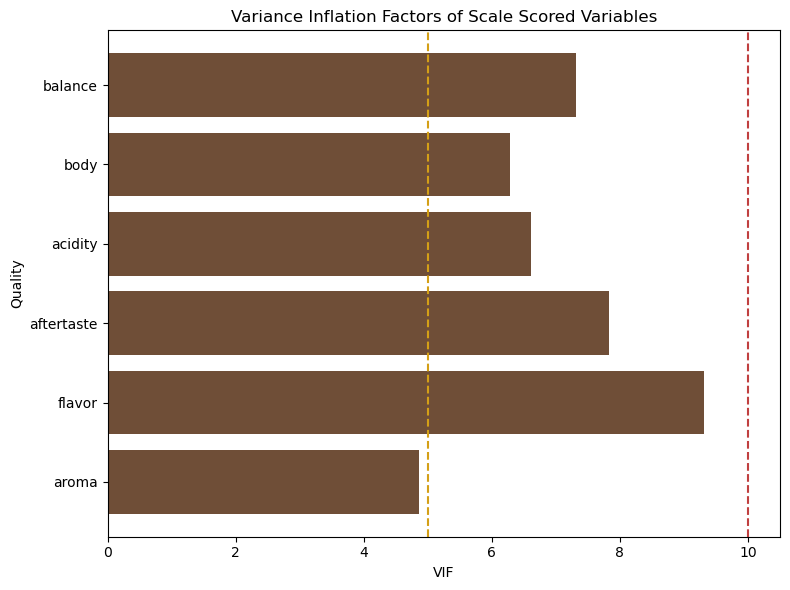

In [46]:
# VIF graph for variables in total_quality

scaler = StandardScaler()
standard_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'altitude', 'moisture']
coffee[standard_cols] = scaler.fit_transform(coffee[standard_cols])
X = coffee.loc[:, 'aroma':'balance']

vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

plt.figure(figsize=(8,6))
plt.barh(vif_df['variable'], vif_df['VIF'], color=['#6F4E37'])
plt.axvline(5, color="#D4A017", linestyle='--')
plt.axvline(10, color='#C04040', linestyle='--')
plt.xlabel("VIF")
plt.ylabel("Quality")
plt.title("Variance Inflation Factors of Scale Scored Variables")
plt.tight_layout()
plt.show()

### Buttons for VIF Plot:

- Select which variables to include in graph
- Select whether to sort by ascending/descending order or order in dataframe (normal)
- Click to include either dotted line (VIF = 5 meaning might be colinearity; VIF = 10 meaning colinearity is most likely present)

/var/folders/k2/xkhh4x_x2999dprlhrz1h_r00000gn/T/ipykernel_80517/206564701.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




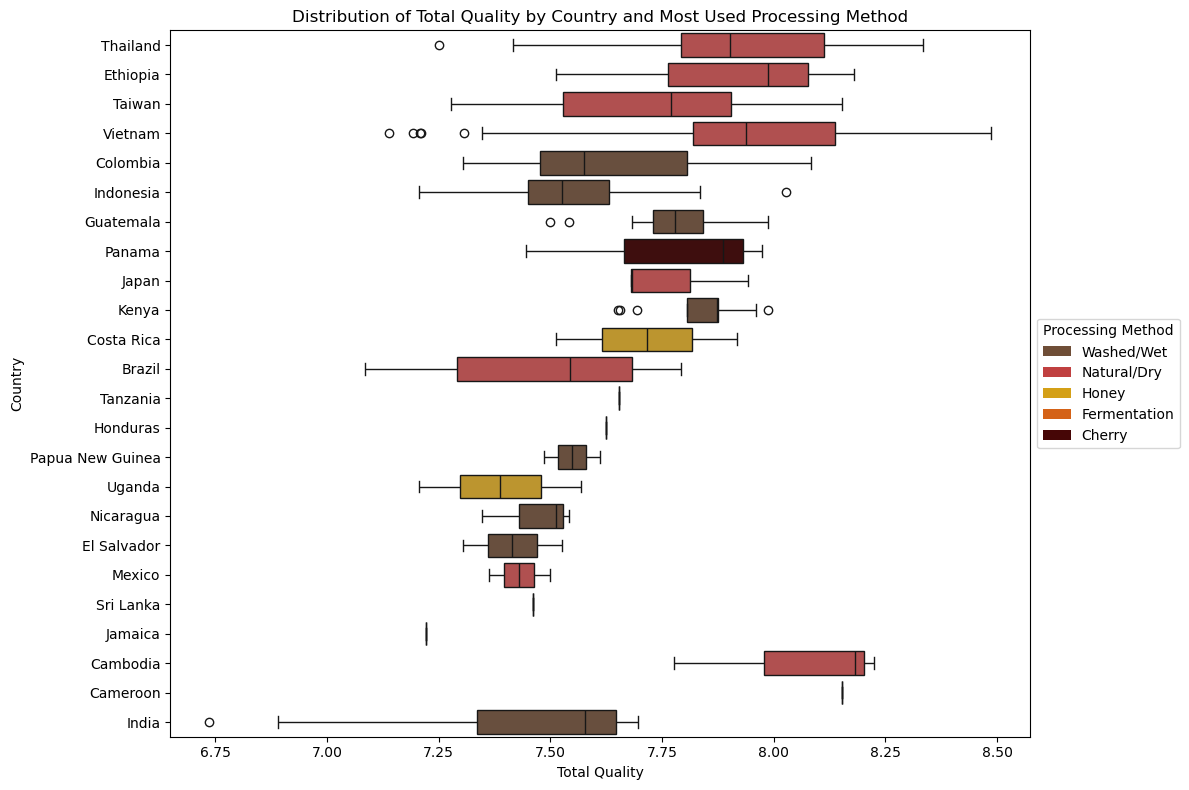

In [67]:
# Observe total_quality grouped by country and most used processing method

coffee['country'] = coffee['country'].replace({
    "Tanzania, United Republic Of": "Tanzania"
})


mode_processing = coffee.groupby('country')['processing_method'] \
                       .agg(lambda x: x.mode()[0])

processing_palette = {
    'Washed/Wet': '#6F4E37',     
    'Natural/Dry': '#C04040',    
    'Honey': '#D4A017',
    'Fermentation': "#D46217",
    'Cherry': "#460606"      
}

plt.figure(figsize=(12,8))

country_colors = mode_processing.map(processing_palette)

processing_dict = country_colors.to_dict()

sns.boxplot(
    y='country',          
    x='total_quality',    
    data=coffee,
    palette=processing_dict       
)

plt.title("Distribution of Total Quality by Country and Most Used Processing Method")
plt.ylabel("Country")
plt.xlabel("Total Quality")

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=method) 
                   for method, color in processing_palette.items()]
plt.legend(handles=legend_elements, title="Processing Method", 
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Buttons for Boxplot:

- Add/remove processing method

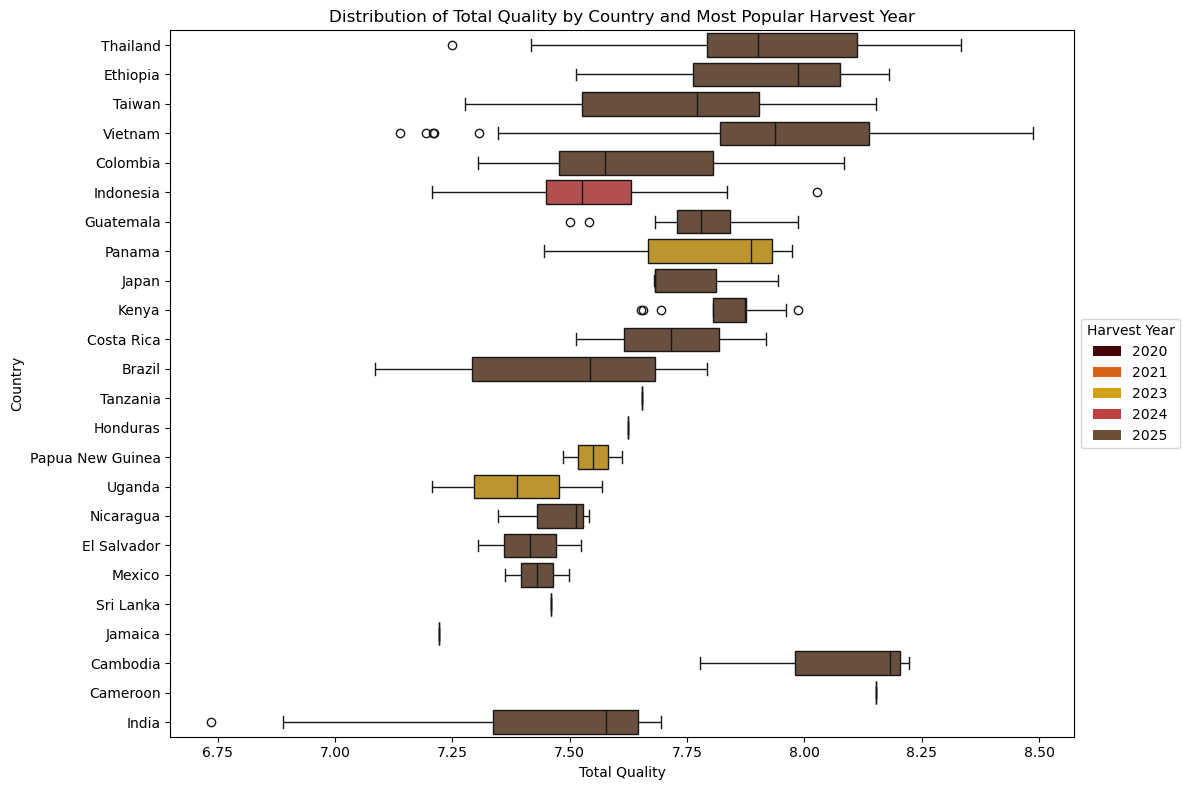

In [69]:
from matplotlib.patches import Patch

coffee['country'] = coffee['country'].replace({
    "Tanzania, United Republic Of": "Tanzania"
})

coffee = coffee.dropna(subset=['harvest_year'])
coffee = coffee[coffee['harvest_year'] != 2026]

mode_harvest = coffee.groupby('country')['harvest_year'].agg(lambda x: x.mode()[0])

coffee['mode_harvest_year'] = coffee['country'].map(mode_harvest)
coffee['mode_harvest_year'] = coffee['mode_harvest_year'].astype(str) 

harvest_palette = {
    '2020': "#460606",
    '2021': "#D46217",
    '2023': "#D4A017",
    '2024': "#C04040",
    '2025': "#6F4E37"
}

plt.figure(figsize=(12,8))

sns.boxplot(
    y='country',                 
    x='total_quality',
    hue='mode_harvest_year',    
    data=coffee,
    palette=harvest_palette,
    dodge=False                  
)

plt.title("Distribution of Total Quality by Country and Most Popular Harvest Year")
plt.xlabel("Total Quality")
plt.ylabel("Country")

legend_elements = [
    Patch(facecolor=color, label=year) 
    for year, color in harvest_palette.items()
]

plt.legend(
    handles=legend_elements,
    title="Harvest Year",
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


### Buttons for Boxplot:

- Add/remove harvest year grouping